# Single-atom response : High Harmonic Generation 
(Lewestein Model)

[from E. Priori et.al., PHYSICAL REVIEW A, VOLUME 61, 063801 (2000)]


In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt

def prepare_hhg(t,E):
    N = t.size
    dt = (t[-1] - t[0]) / (N - 1)
    A = np.zeros(N)
    int_A = np.zeros(N)
    int_A2 = np.zeros(N)
    for it in range(1,N):
        A[it] = A[it-1] - E[it-1]*dt
        int_A[it] = int_A[it-1] + A[it-1]*dt
        int_A2[it] = int_A2[it-1] + A[it-1]**2*dt
    return A, int_A, int_A2

For hydrogenlike atom, dipole matrix element for transitions from ground state to a continuum state with momentum p is :

$d(p) = i \dfrac{2^{7/2}(2I_p)^{5/4}}{\pi} \dfrac {p} {(p^2+2I_p)^3}$


In [2]:
@nb.jit('complex128(f8,f8)')
def dipole(p, Ip):
    alpha = 2*Ip
    return 1j * 2**3.5 * alpha**1.25 * p / (np.pi * (p*p+alpha)**3)

Saddle point solutions:

The stationary values of momentum  is 

$P_{st}(t', t) = \dfrac{1} {t-t'} \int_{t'}^{t} A(t'') dt''$

The quasiclassical action is 

$S_{st}(t', t) = (t-t')I_p - \frac{1}{2}P_{st}^2(t', t) + \frac{1}{2}\int_{t'}^{t} A^2(t'') dt''$

The non linear diple moment is 

$d_{nl}(t) = 2 Re \Bigl[ \int_{-\infty}^t \bigl(\dfrac{\pi} { \epsilon+i(t-t')/2}\bigr)^{3/2} \\ 
\times d^*[P_{st}(t', t) - A(t)] \times d[P_{st}(t', t) - A(t')] \\ 
\times exp[-iS_{st}(t', t)]E(t') \Bigr]$


In [7]:
@nb.njit('f8[:](f8[:],f8[:],f8[:],f8[:],f8[:],f8,f8)', parallel=True)
def hhg_cal(t, E,  A, int_A, int_A2, Ip, eps): 
    N = t.size 
    dt = (t[-1]-t[1])/(N-1)
    dout = np.zeros(N)
    ps_t_tau = 0
    Ss_t_tau = 0    
    d = 0+1j*0
    for it in nb.prange(N):
        d = 0+1j*0
        for itau in nb.prange(1,it): #return time
            itp = it - itau #ionization time
            ps_t_tau = (int_A[it]-int_A[itp])/(itau*dt)                
            Ss_t_tau = Ip*itau*dt - 0.5*ps_t_tau**2*itau*dt +0.5*(int_A2[it]-int_A2[itp])
            c = np.pi/(eps*Ip+1j*itau*dt/2)
            d += np.conj(dipole(ps_t_tau - A[it], Ip)) \
                *dipole(ps_t_tau - A[itp], Ip)*E[itp] \
                *np.exp(-1j*Ss_t_tau)*c*np.sqrt(c)
        d *= dt*1j
        dout[it] = 2*np.real(d)
    return dout

In [8]:
#preparing pulse
t0, t1, nt = -500., 500., 1001 
E0, w0, sigma = 0.076, 0.057, 206.7

dt = (t1 - t0) / (nt - 1)

t = np.linspace(t0, t1, nt)
Ef = E0 * np.exp(-t**2/sigma**2) * np.cos(w0*t)

A, int_A, int_A2 = prepare_hhg(t, Ef)

#dipole moments
d = hhg_cal(t, Ef, A, int_A,int_A2, 0.5, 0.01)

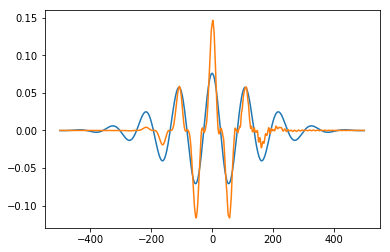

In [9]:
plt.figure(1)
plt.plot(t, Ef)
plt.plot(t, d)
plt.show()

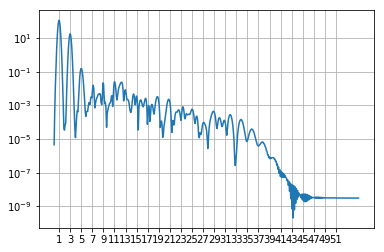

In [10]:
order = np.fft.fftfreq(nt, dt/(2*np.pi/w0))
ids = np.where(order>0)
order = order[ids]
signal = np.fft.fft(d)[ids]
plt.figure(2)
plt.plot(order, np.abs(signal)**2)
plt.yscale('log')
gridx = np.arange(1,53,2)
plt.xticks(gridx)
plt.grid()